In [1]:
import unittest
from time import time, ctime

# CONSTANT
DATA_ROOT = "./data"
DBLP_PATH = DATA_ROOT + "/dblp"
AMAZON_PATH = DATA_ROOT + "/amazon"
FACEBOOK_PATH = DATA_ROOT + "/facebook"
NOTIFY_ENDPOINT = r"https://notify.run/O6EfLmG6Tof1s5DljYB7"


import pandas as pd

from package.model import DiffusionModel
from package.topic import TopicModel
from package.social_graph import SN_Graph
from package.itemset import ItemsetFlyweight, ItemRelation
from package.utils import getItemsPrice, read_items
from package.algorithm import Algorithm

NUM_TOPICS = 5
TOPICS = {
    "Node": {
        "0": [0.9, 0.1, 0.0],
        "1": [0.2, 0.8, 0.0],
        "2": [0.8, 0.2, 0.0],
        "3": [0.2, 0.4, 0.4],
    },
    "Item": {
        "iPhone": [0.7, 0.0, 0.3],
        "AirPods": [0.9, 0.0, 0.1],
        "Galaxy": [0.0, 0.8, 0.2],
    }
}
PRICES = {
    "iPhone": 50,
    "AirPods": 5,
    "Galaxy": 60,
}
RELATION = pd.DataFrame.from_dict({
            "iPhone":{
                "AirPods":10,
                "Galaxy":-5
            },
            "AirPods":{
                "iPhone":1,
                "Galaxy":0,
            },
            "Galaxy":{
                "iPhone":-8,
                "AirPods":1,
            }
            })

## 確認收斂次數

In [2]:
items = read_items(AMAZON_PATH + "/sample_items.csv")

topicModel = TopicModel(NUM_TOPICS)
topicModel.read_topics(node_file=FACEBOOK_PATH + "/nodes_with_" + str(NUM_TOPICS) + "_topic.csv",
                        items_file=AMAZON_PATH + "/items_with_" + str(NUM_TOPICS) + "_topic.csv")

graph = SN_Graph.construct(FACEBOOK_PATH + "/edges", topicModel, located=False)

relation = ItemRelation()
relation.construct(AMAZON_PATH + "/sample_items.csv")
itemset = ItemsetFlyweight(getItemsPrice(AMAZON_PATH + "/sample_items.csv"), topicModel, relation)

model = DiffusionModel("amazon in dblp", graph, itemset, threshold=0)
seed_size = min(itemset.size, graph.number_of_nodes())
seeds = model.selectSeeds(seed_size)
model.allocate(seeds, [itemset[asin] for asin in itemset.PRICE.keys()])

simluation_times = 10000
algo = Algorithm(model, 0, simulationTimes=simluation_times)
performanceFile = r"./result/mainitemset.txt"
candidatedCoupons = algo.genAllCoupons(10)

for k in range(1,2):
    algo.setLimitCoupon(k)
    start_time = time()
    if k == 0:
        outputCoupons, tagger = algo.simulation([])
    else:
        outputCoupons, tagger = algo.simulation(candidatedCoupons)

    end_time = time()
        
    # with open(performanceFile, "a") as record:
        
    #     record.write("{0},runtime={1},revenue={2},expected_revenue={3},active_node={4},expected_active_node={5},k={6},non_active={7}\n".format(
    #         ctime(end_time),
    #         (end_time - start_time),
    #         tagger["TagRevenue"].amount(),
    #         tagger["TagRevenue"].expected_amount(),
    #         tagger["TagActiveNode"].amount(),
    #         tagger["TagActiveNode"].expected_amount(),
    #         k,
    #         tagger["TagNonActive"].amount(),
    #         ))
        
    #     for c in outputCoupons:
    #         record.write(str(c) + "\n")
    #     record.write("\n")
tagger["TagDecidedMainItemset"].avg(simluation_times)

Constructing graph...
Connecting the edges...Done


In [26]:
import numpy as np
colors = {"B000VYIUJS":"64e9c0", "B000JX5JGI": "cbb446", "B000JX5JGI B000VYIUJS":"ba9800"}
for k,l in tagger["TagDecidedMainItemset"].items():
    print(k)
    print(l)
    # colors[k] = ((np.random.random(), np.random.random(), np.random.random()))

B000JX5JGI
[1.0, 2.64, 2.63, 2.78, 2.69, 2.4, 2.06, 1.58, 1.59, 1.1, 0.95, 0.76, 0.51, 0.42, 0.3, 0.28, 0.11, 0.04, 0.06, 0.05, 0.02, 0.06, 0.02, 0.01]
B000VYIUJS
[1.0, 1.98, 1.95, 1.92, 1.68, 1.62, 1.47, 1.35, 0.94, 0.68, 0.52, 0.52, 0.42, 0.42, 0.38, 0.38, 0.23, 0.15, 0.12, 0.08, 0.14, 0.09, 0.12, 0.1, 0.06, 0.02, 0.03, 0.06, 0.02]
B000JX5JGI B000VYIUJS
[0.0, 0.0, 0.05, 0.03, 0.08, 0.08, 0.06, 0.11, 0.05, 0.06, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.01, 0.0, 0.0, 0.01]


C:\Users\user\AppData\Local\Temp\ipykernel_20168\3319391714.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(list(range(len(v))), v, 'ko--', color=colors[k], label=k, markerfacecolor='none')


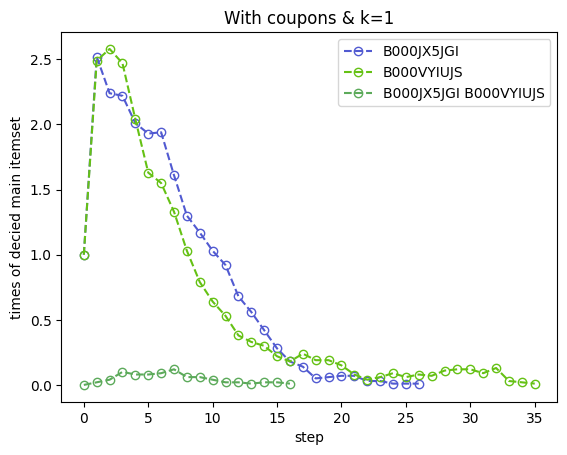

In [39]:
import matplotlib.pyplot as plt

plt.figure("Main Itemset")
for k,v in tagger["TagDecidedMainItemset"].items():
    plt.plot(list(range(len(v))), v, 'ko--', color=colors[k], label=k, markerfacecolor='none')
plt.title("Withput coupons")
plt.xlabel("step")
plt.ylabel("times of decied main itemset")
plt.legend()

In [11]:
str(outputCoupons[0])

'32.31,B000JX5JGI B000VYIUJS,5.0,B000VYIUJS'

### 可累積商品和累積門檻條件的變化對於使用者CP值感知的影響

In [1]:
import pandas as pd

from package.model import DiffusionModel
from package.topic import TopicModel
from package.social_graph import SN_Graph
from package.itemset import ItemsetFlyweight, ItemRelation
from package.utils import getItemsPrice, read_items
from package.algorithm import Algorithm
from package.coupon import Coupon
from package.user_proxy import UsersProxy

NUM_TOPICS = 5
TOPICS = {
    "Node": {
        "0": [0.9, 0.1, 0.0],
        "1": [0.2, 0.8, 0.0],
        "2": [0.8, 0.2, 0.0],
        "3": [0.2, 0.4, 0.4],
    },
    "Item": {
        "iPhone": [0.7, 0.0, 0.3],
        "AirPods": [0.9, 0.0, 0.1],
        "Galaxy": [0.0, 0.8, 0.2],
    }
}
PRICES = {
    "iPhone": 260.0,
    "AirPods": 60.0,
    "Galaxy": 500.0,
}
RELATION = pd.DataFrame.from_dict({
            "iPhone":{
                "AirPods":10,
                "Galaxy":-5
            },
            "AirPods":{
                "iPhone":1,
                "Galaxy":0,
            },
            "Galaxy":{
                "iPhone":-8,
                "AirPods":1,
            }
            })

topicModel = TopicModel(3, TOPICS["Node"], TOPICS["Item"])
relation = ItemRelation(RELATION)
itemset = ItemsetFlyweight(prices = PRICES, topic = topicModel.getItemsTopic(), relation=relation)
graph = SN_Graph(topicModel.getNodesTopic())
coupon = Coupon(30, itemset["Galaxy"], 50, itemset["Galaxy"])
user_proxy = UsersProxy(graph, itemset, [coupon], 0)
graph.add_node("0", adopted_set=None, desired_set=itemset["Galaxy"], topic=TOPICS["Node"]["0"])

In [10]:
import matplotlib.pyplot as plt
import numpy as np

step = 20
# 可累積商品
x_line = list() 

# 累積門檻
y_line = list(np.arange(itemset["Galaxy"].price, itemset["Galaxy iPhone AirPods"].price+step*10, step))

# 折抵金額
z_line = list(np.arange(0, itemset["Galaxy iPhone AirPods"].price, step))

point_VP = dict()
point_amount = dict()

for key, accItemset in itemset:
    
    if not itemset.issubset(itemset["Galaxy"], accItemset):
        continue
    x_line.append(key)
    coupon.accItemset = accItemset
    point_VP[key] = []
    point_amount[key] = []
    
    for i in range(len(z_line)):
        coupon.discount = z_line[i]
    
        point_VP[key].append([])
        point_amount[key].append([])

        for threshold in y_line:
            coupon.accThreshold = threshold

            user_proxy.setCoupons([coupon])
            graph._initNode("0")
            graph.nodes["0"]["desired_set"] = itemset["Galaxy"]
            
            result = user_proxy.adopt("0")
            
            for k,v in result.items():
                print(k, v)
            print("-----------------------")
            
            point_VP[key][i].append(result["VP"])
            point_amount[key][i].append(result["amount"])
            


mainItemset Galaxy
decision_items AirPods Galaxy
tradeOff_items AirPods Galaxy
amount 560.0
coupon 500.0,Galaxy,0.0,Galaxy
VP 0.0008000250685711635
-----------------------
mainItemset Galaxy
decision_items Galaxy
tradeOff_items Galaxy
amount 500.0
coupon None
VP 0.00016000000000000004
-----------------------
mainItemset Galaxy
decision_items Galaxy
tradeOff_items Galaxy
amount 500.0
coupon None
VP 0.00016000000000000004
-----------------------
mainItemset Galaxy
decision_items Galaxy
tradeOff_items Galaxy
amount 500.0
coupon None
VP 0.00016000000000000004
-----------------------
mainItemset Galaxy
decision_items Galaxy
tradeOff_items Galaxy
amount 500.0
coupon None
VP 0.00016000000000000004
-----------------------
mainItemset Galaxy
decision_items Galaxy
tradeOff_items Galaxy
amount 500.0
coupon None
VP 0.00016000000000000004
-----------------------
mainItemset Galaxy
decision_items Galaxy
tradeOff_items Galaxy
amount 500.0
coupon None
VP 0.00016000000000000004
-----------------------


In [ ]:
# colors = dict()
# markers_all = ["*", "o", "v", "^", "s", "p"]
# markers = dict()
# for k in x_line:
#     colors[k] = ((np.random.random(), np.random.random(), np.random.random()))
#     markers[k] = markers_all[np.random.randint(0, len(markers_all))]

In [12]:
print(y_line)
print(point_VP[accItemset])

[500.0, 520.0, 540.0, 560.0, 580.0, 600.0, 620.0, 640.0, 660.0, 680.0, 700.0, 720.0, 740.0, 760.0, 780.0, 800.0, 820.0, 840.0, 860.0, 880.0, 900.0, 920.0, 940.0, 960.0, 980.0, 1000.0]
[[0.0008000250685711635, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004], [0.0008296556266663917, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004, 0.00016000000000000004

ValueError: x and y must be the same size

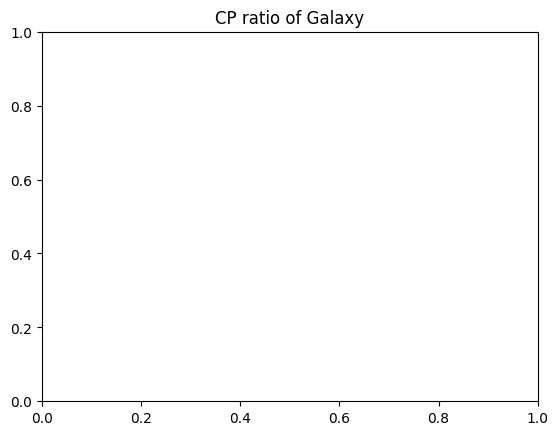

In [11]:
plt.figure("VP")
for x in x_line:
    plt.plot(x[k], v, 'k' + markers[k] + '--', color=colors[k], label=k, markerfacecolor='none')
plt.xlabel("threshold")
plt.ylabel("value")
plt.legend()

plt.figure("Checkout amount")
for k,v in y_price.items():
    plt.plot(x[k], v, 'k' + markers[k] + '--', color=colors[k], label=k, markerfacecolor='none')
plt.xlabel("threshold")
plt.ylabel("value")
plt.legend()

# for accItemset in x_line:
#     plt.figure("CP ratio of {0}".format(accItemset))
#     plt.title("CP ratio of {0}".format(accItemset))
#     plt.scatter(x = y_line, y = point_VP[accItemset], colors = z_line, cmap = "Blues_r")
#     plt.colorbar()
#     plt.show()